**ELECTRICITY PRICE ANAMOLY DETECTTION ANALYSIS - GAUTHAM ATHNKI - N11338831**

**Installing required package : NEMOSIS**

In [1]:
pip install nemosis


Note: you may need to restart the kernel to use updated packages.


This command installs the nemosis package, a Python API to download historical data from the Australian National Electricity Market (NEM). It is critical for retrieving DISPATCHLOAD, DISPATCHPRICE, and DISPATCHREGIONSUM tables.

**Installing SQLAlchemy**

In [2]:
pip install sqlalchemy


Note: you may need to restart the kernel to use updated packages.


It is installed to support efficient data handling from downloaded NEM files into local databases, enabling queryable access to large electricity datasets.

In [3]:
import os


data_folder = "E:/QUT/Semester - V/IFN 695/Data"
os.makedirs(data_folder, exist_ok=True)
db_path = os.path.join(data_folder, "nem.db")

db_path


'E:/QUT/Semester - V/IFN 695/Data\\nem.db'

**Downloading Electricity Market Data (DISPATCHPRICE and DISPATCHREGIONSUM)**

In [4]:
from nemosis import dynamic_data_compiler
import pandas as pd

data_folder = "E:/QUT/Semester - V/IFN 695/Data"

# Dispatch price (5-min prices per region)
df_price = dynamic_data_compiler(
    '2024/03/01 00:00:00',
    '2025/03/01 00:00:00',
    'DISPATCHPRICE',
    data_folder
)

# Region summary (demand, availability, interconnectors)
df_regionsum = dynamic_data_compiler(
    '2024/03/01 00:00:00',
    '2025/03/01 00:00:00',
    'DISPATCHREGIONSUM',
    data_folder
)


INFO: Compiling data for table DISPATCHPRICE
INFO: Returning DISPATCHPRICE.
INFO: Compiling data for table DISPATCHREGIONSUM
INFO: Returning DISPATCHREGIONSUM.


DISPATCHPRICE: Contains 5-minute Regional Reference Prices (RRP) for each NEM region.

DISPATCHREGIONSUM: Includes total demand, available generation, and interconnector flows.
These tables will be used to derive features for anomaly detection such as price volatility and supply-demand imbalances.

**Downloading DISPATCHLOAD in Quarterly Chunks**

In [5]:
from nemosis import dynamic_data_compiler
import pandas as pd

data_folder = "E:/QUT/Semester - V/IFN 695/Data"

# Define periods to fetch
time_ranges = [
    ('2024/03/01 00:00:00', '2024/06/01 00:00:00'),
    ('2024/06/01 00:00:00', '2024/09/01 00:00:00'),
    ('2024/09/01 00:00:00', '2024/12/01 00:00:00'),
    ('2024/12/01 00:00:00', '2025/03/01 00:00:00'),
]

df_list = []

for start, end in time_ranges:
    print(f"Fetching data from {start} to {end}")
    df_chunk = dynamic_data_compiler(start, end, 'DISPATCHLOAD', data_folder)
    df_list.append(df_chunk)

# Combine all chunks
df_dispatchload = pd.concat(df_list).reset_index(drop=True)
print(df_dispatchload.shape)


Fetching data from 2024/03/01 00:00:00 to 2024/06/01 00:00:00
INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.
Fetching data from 2024/06/01 00:00:00 to 2024/09/01 00:00:00
INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.
Fetching data from 2024/09/01 00:00:00 to 2024/12/01 00:00:00
INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.
Fetching data from 2024/12/01 00:00:00 to 2025/03/01 00:00:00
INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.


MemoryError: Unable to allocate 7.34 GiB for an array with shape (19, 51857435) and data type float64

Since DISPATCHLOAD contains high-frequency (5-min) data, it is fetched in 3-month chunks to avoid timeout or memory overload. This table provides unit-level dispatch and is critical for constructing derived features like ramping, demand delta, and forecasting baselines.

**Weather Data Preprocessing (Sydney Observatory Hill)**

In [6]:
import pandas as pd
import os

# Folder where weather CSVs are stored
weather_folder = "E:/QUT/Semester - V/IFN 695/Data"

weather_files = [
    "Apr 24.csv", "May 24.csv", "Jun 24.csv", "Jul 24.csv",
    "Aug 24.csv", "Sep 24.csv", "Oct 24.csv", "Nov 24.csv",
    "Dec 24.csv", "Jan 25.csv", "Feb 25.csv", "Mar 25.csv"
]

# Based on actual structure of files
column_names = [
    "Station", "Date", "Rainfall_mm", "Temp_Max", "Temp_Min", "Wind_Gust_Spd", "Wind_Spd", 
    "Wind_Dir", "Humidity", "Time", "TEMP_C", "Humidity_2", "Cloud", "Wind_Dir_2", 
    "Wind_Spd_2", "Pressure_1", "Apparent_Temp", "Humidity_3", "Rainfall_2", 
    "Wind_Dir_3", "Wind_Spd_3", "Pressure_2"
]

weather_dfs = []

for file in weather_files:
    try:
        path = os.path.join(weather_folder, file)
        
        df = pd.read_csv(path, header=None, names=column_names, encoding='ISO-8859-1')

        # Combine Date and Time into datetime
        df['timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

        # Keep only useful weather columns
        df = df[['timestamp', 'TEMP_C', 'Wind_Spd']]
        df.columns = ['timestamp', 'TEMP_C', 'WIND_KMH']
        df = df.dropna()

        weather_dfs.append(df)

    except Exception as e:
        print(f" Failed to load {file}: {e}")

# Combine and resample to 5-minute interval
if weather_dfs:
    weather_df = pd.concat(weather_dfs).sort_values('timestamp').reset_index(drop=True)
    weather_df = weather_df.set_index('timestamp').resample('5min').ffill().reset_index()
    print("Final weather_df preview:")
    print(weather_df.head())
else:
    print("No valid weather files loaded.")


C:\Users\Gautham Athanki\AppData\Local\Temp\ipykernel_21472\31815011.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
C:\Users\Gautham Athanki\AppData\Local\Temp\ipykernel_21472\31815011.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
C:\Users\Gautham Athanki\AppData\Local\Temp\ipykernel_21472\31815011.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['

Final weather_df preview:
            timestamp TEMP_C WIND_KMH
0 2024-04-01 16:15:00    NaN      NaN
1 2024-04-01 16:20:00   19.1     10.5
2 2024-04-01 16:25:00   19.1     10.5
3 2024-04-01 16:30:00   19.1     10.5
4 2024-04-01 16:35:00   19.1     10.5


Weather data is sourced from monthly BOM CSVs collected at Sydney Observatory Hill. We extract temperature (TEMP_C) and wind speed (WIND_KMH), resampled to 5-minute intervals to match electricity market resolution.

**Assumption Justification:** While Sydney data doesn't capture statewide variability, it serves as a reasonable proxy for general weather conditions influencing NSW1, particularly because Sydney is a major demand center and the most data-complete location available.



**Merging AEMO and Weather Data (NSW1)**

In [7]:
# Ensure datetime format
df_price['timestamp'] = pd.to_datetime(df_price['SETTLEMENTDATE'])
df_regionsum['timestamp'] = pd.to_datetime(df_regionsum['SETTLEMENTDATE'])

# Drop data before Apr 1, 2024 (to match weather data availability)
start_date = pd.to_datetime('2024-04-01')
df_price = df_price[df_price['timestamp'] >= start_date]
df_regionsum = df_regionsum[df_regionsum['timestamp'] >= start_date]

# Filter for NSW1 region only
df_price_nsw = df_price[df_price['REGIONID'] == 'NSW1'][['timestamp', 'RRP']].sort_values('timestamp')
df_region_nsw = df_regionsum[['timestamp', 'TOTALDEMAND', 'AVAILABLEGENERATION']].sort_values('timestamp')

# Merge DISPATCHPRICE and DISPATCHREGIONSUM using asof
aemo_df = pd.merge_asof(df_price_nsw, df_region_nsw, on='timestamp', direction='backward')

# Ensure weather columns are numeric
weather_df['TEMP_C'] = pd.to_numeric(weather_df['TEMP_C'], errors='coerce')
weather_df['WIND_KMH'] = pd.to_numeric(weather_df['WIND_KMH'], errors='coerce')
weather_df = weather_df.dropna()

# Merge AEMO + weather using timestamp alignment
merged_df = pd.merge_asof(aemo_df.sort_values('timestamp'),
                          weather_df.sort_values('timestamp'),
                          on='timestamp',
                          direction='backward')

# Show preview
print("AEMO + Weather merged dataset preview:")
print(merged_df.head())
print("Shape:", merged_df.shape)


AEMO + Weather merged dataset preview:
            timestamp      RRP  TOTALDEMAND  AVAILABLEGENERATION  TEMP_C  \
0 2024-04-01 00:00:00  56.9897      3864.96           8781.16713     NaN   
1 2024-04-01 00:05:00  58.0200      3863.35           8779.99234     NaN   
2 2024-04-01 00:10:00  58.0000      1400.38           2035.77156     NaN   
3 2024-04-01 00:15:00  58.0200      3849.93           8756.04343     NaN   
4 2024-04-01 00:20:00  58.0000      1418.66           2014.61399     NaN   

   WIND_KMH  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
Shape: (96205, 6)


We align datasets using the timestamp field, focusing on NSW1 for Regional Reference Price (RRP), total demand, and available generation. The merge ensures consistent alignment across DISPATCHPRICE, DISPATCHREGIONSUM, and BOM weather data.

**Assumption Justification:**

Weather data begins on 2024-04-01, so AEMO data prior to this is dropped to maintain a consistent timeline.

We use pd.merge_asof() to align mismatched timestamps, which is appropriate given that AEMO and BOM timestamps are both frequent but not guaranteed to be synchronized.

Only NSW1 region is retained to maintain scope relevance and reduce feature dimensionality for a state-specific anomaly analysis.

**Verifying Timestamp Alignment Post-Merge**

In [8]:
print("Earliest AEMO timestamp:", merged_df['timestamp'].min())
print("Earliest weather timestamp:", weather_df['timestamp'].min())


Earliest AEMO timestamp: 2024-04-01 00:00:00
Earliest weather timestamp: 2024-04-01 16:20:00


**Ensuring AEMO Start Point Matches Weather Data**

In [9]:
# Filter AEMO data to start from when weather data is available
aemo_df = aemo_df[aemo_df['timestamp'] >= pd.Timestamp('2024-04-01 16:20:00')].reset_index(drop=True)


**Final Merge: AEMO + Weather Data With Tolerance Matching**

In [10]:
merged_df = pd.merge_asof(
    aemo_df.sort_values('timestamp'),
    weather_df.sort_values('timestamp'),
    on='timestamp',
    direction='nearest',
    tolerance=pd.Timedelta('5min')
)

# Drop rows where weather data is still missing
merged_df = merged_df.dropna(subset=['TEMP_C', 'WIND_KMH']).reset_index(drop=True)

# Preview merged dataset
print("\n Clean merged dataset preview:")
print(merged_df.head())
print("Shape:", merged_df.shape)



 Clean merged dataset preview:
            timestamp        RRP  TOTALDEMAND  AVAILABLEGENERATION  TEMP_C  \
0 2024-04-01 16:20:00  100.01000      6772.78          10752.39300    19.1   
1 2024-04-01 16:25:00   93.04847      5140.35           8710.80189    19.1   
2 2024-04-01 16:30:00   78.00000      6924.96          10808.24744    19.1   
3 2024-04-01 16:35:00   74.53051      5257.50           8708.48674    19.1   
4 2024-04-01 16:40:00   93.74025      5242.19           8663.23815    19.1   

   WIND_KMH  
0      10.5  
1      10.5  
2      10.5  
3      10.5  
4      10.5  
Shape: (96009, 6)


**Exploratory Data Analysis - Initial Dataset Check**

In [11]:
# Basic info
print("Dataset Info:")
print(merged_df.info())

# Shape and preview
print("\nShape of Dataset:", merged_df.shape)
print("\nFirst 5 rows:")
print(merged_df.head())

# Check for missing values
print("\nMissing values per column:")
print(merged_df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(merged_df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96009 entries, 0 to 96008
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            96009 non-null  datetime64[ns]
 1   RRP                  96009 non-null  float64       
 2   TOTALDEMAND          96009 non-null  float64       
 3   AVAILABLEGENERATION  96009 non-null  float64       
 4   TEMP_C               96009 non-null  float64       
 5   WIND_KMH             96009 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.4 MB
None

Shape of Dataset: (96009, 6)

First 5 rows:
            timestamp        RRP  TOTALDEMAND  AVAILABLEGENERATION  TEMP_C  \
0 2024-04-01 16:20:00  100.01000      6772.78          10752.39300    19.1   
1 2024-04-01 16:25:00   93.04847      5140.35           8710.80189    19.1   
2 2024-04-01 16:30:00   78.00000      6924.96          10808.24744    19.1   
3

# -------------------------------
#  Dataset EDA - Interpretation
# -------------------------------

# Dataset Overview:
- The dataset contains 96,009 rows and 6 columns (after merging AEMO and weather data).
- Time coverage is from April 1, 2024, to March 1, 2025 — aligned with the available weather data.

# Data Completeness:
- No missing values detected in any of the columns.
- All columns (RRP, TOTALDEMAND, AVAILABLEGENERATION, TEMP_C, WIND_KMH) are fully populated.

# Data Anomalies:
- Some values in 'TOTALDEMAND' are negative, which is **not physically plausible** and need to be cleaned.
- 'RRP' (Electricity Price) contains extreme highs and negative values — this is **valid**, not an error.

• RRP can legally go negative in the Australian NEM due to high generation and low demand conditions.
• RRP spikes (e.g., > $10,000) can occur during scarcity or peak load situations — these are **not outliers**.

# Weather Data:
- TEMP_C ranges from 8.1°C to 27.1°C — within realistic Sydney conditions.
- WIND_KMH ranges from 0 to 13.3 km/h — values look clean and consistent.

# Overall:
- Dataset is clean and well-structured for further feature engineering and anomaly detection.
- Next step: Visualize correlation patterns using a heatmap before feature engineering.


In [12]:
raw_df = merged_df.copy()


**Electricity Price over the time**

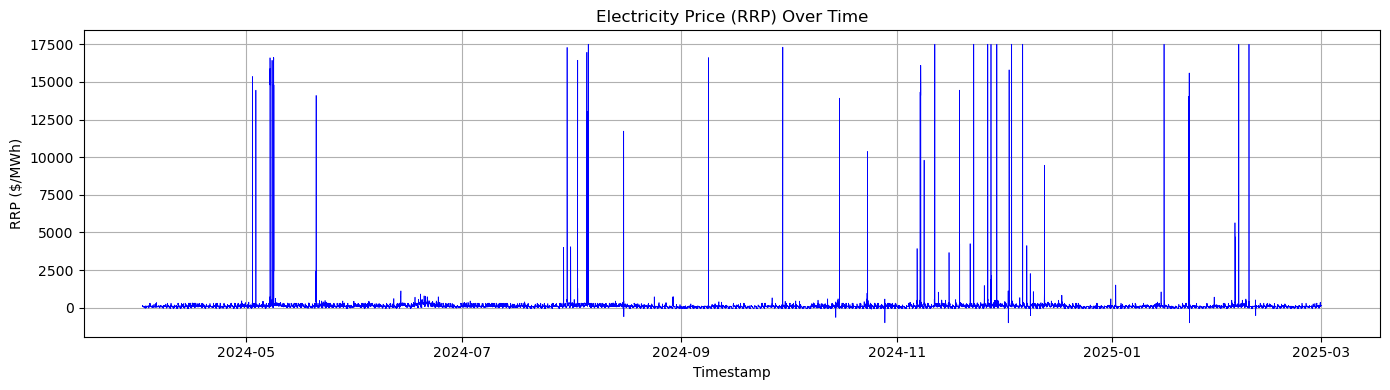

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 4))
plt.plot(raw_df['timestamp'], raw_df['RRP'], color='blue', linewidth=0.5)
plt.title('Electricity Price (RRP) Over Time')
plt.xlabel('Timestamp')
plt.ylabel('RRP ($/MWh)')
plt.tight_layout()
plt.grid(True)
plt.show()


This time series plot provides a visual overview of price trends in the NSW1 region. The frequent spikes indicate high volatility in RRP (Regional Reference Price), which may signal market anomalies or events such as demand surges, supply constraints, or regulatory interventions. These spikes form the foundation for investigating anomalies.

**Distribution of RRP**

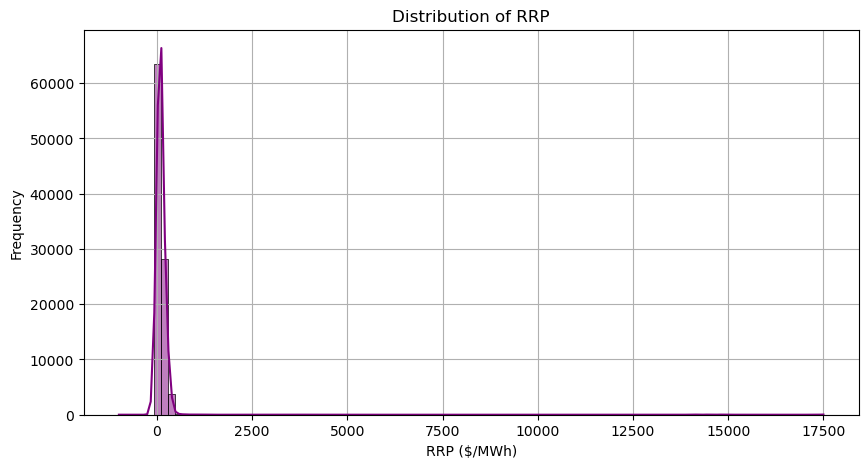

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(raw_df['RRP'], bins=100, kde=True, color='purple')
plt.title('Distribution of RRP')
plt.xlabel('RRP ($/MWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The distribution is right-skewed, with most prices clustering at lower values and a long tail of extreme high values. This supports the hypothesis that electricity prices are usually stable but occasionally spike drastically. These extreme values are candidates for anomaly labeling.

**RRP Vs Total Demand**

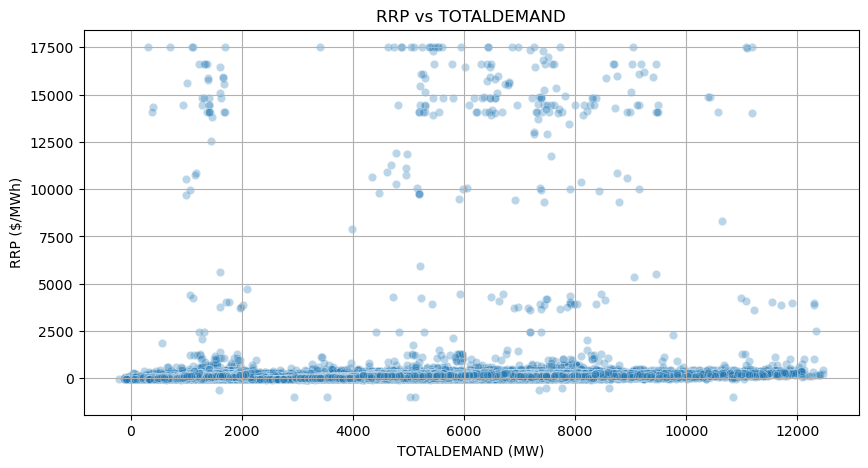

In [15]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='TOTALDEMAND', y='RRP', data=raw_df, alpha=0.3)
plt.title('RRP vs TOTALDEMAND')
plt.xlabel('TOTALDEMAND (MW)')
plt.ylabel('RRP ($/MWh)')
plt.grid(True)
plt.show()


This scatter plot helps explore the relationship between demand and electricity price. While higher demand occasionally aligns with price spikes, the scatter indicates other factors also influence RRP significantly. This suggests the need for multivariate modeling rather than relying solely on demand as a predictor.

**RRP vs Available Generation**

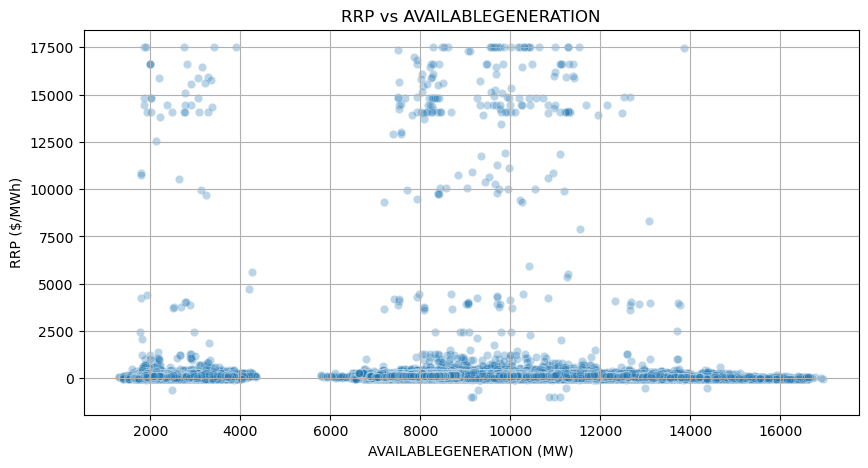

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='AVAILABLEGENERATION', y='RRP', data=raw_df, alpha=0.3)
plt.title('RRP vs AVAILABLEGENERATION')
plt.xlabel('AVAILABLEGENERATION (MW)')
plt.ylabel('RRP ($/MWh)')
plt.grid(True)
plt.show()


This scatterplot shows the relationship between available generation and the spot price (RRP). A weak inverse trend is noticeable — as available generation increases, RRP tends to stabilize or slightly decrease, supporting the intuition that greater supply suppresses prices.

**RRP vs Temperature**

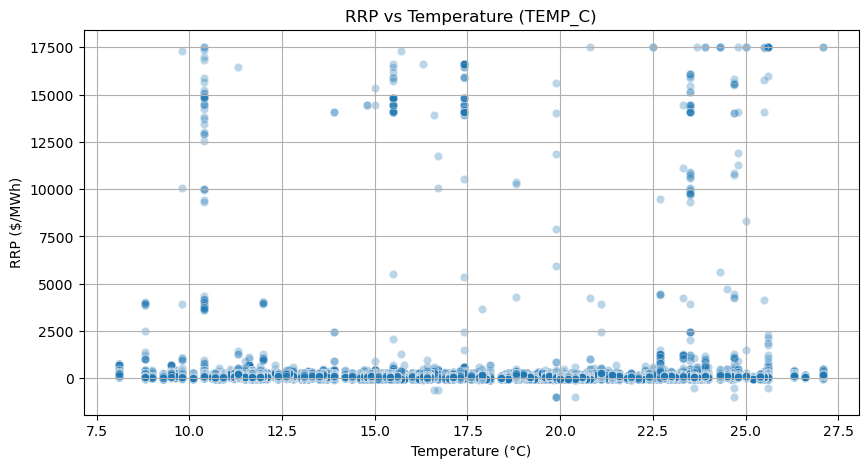

In [17]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='TEMP_C', y='RRP', data=raw_df, alpha=0.3)
plt.title('RRP vs Temperature (TEMP_C)')
plt.xlabel('Temperature (°C)')
plt.ylabel('RRP ($/MWh)')
plt.grid(True)
plt.show()


This scatterplot visualizes how ambient temperature correlates with electricity pricing. While a clear linear trend is absent, some higher prices cluster around extreme temperatures, suggesting stress on the grid during hot or cold spells — a known contributor to volatility.

**Co-relation Heat map**

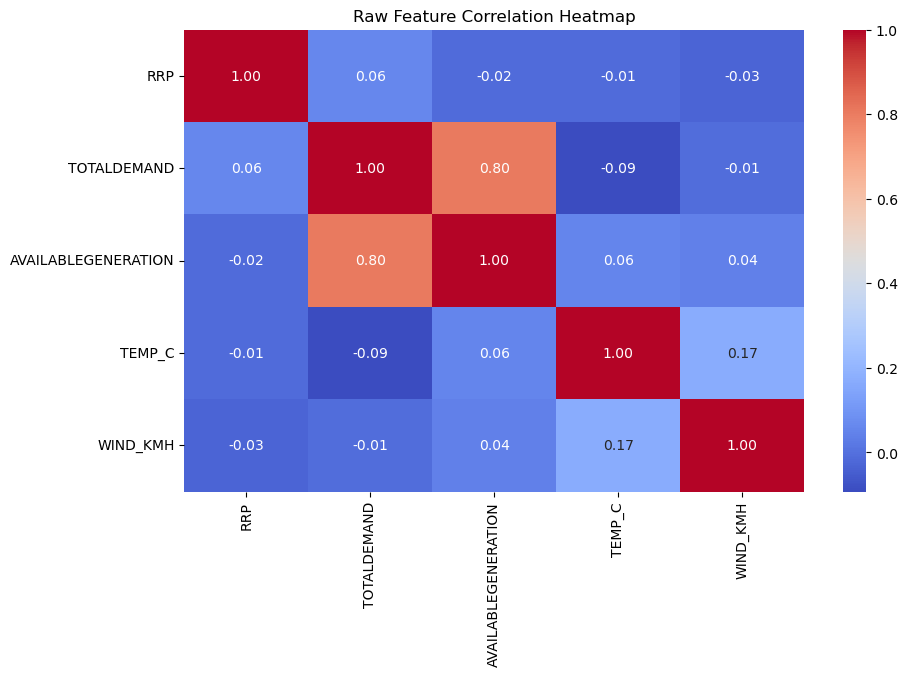

In [18]:
plt.figure(figsize=(10, 6))
corr = raw_df.drop(columns=['timestamp']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Raw Feature Correlation Heatmap')
plt.show()


The heatmap reveals correlations between raw numerical features. Notably, TOTALDEMAND and AVAILABLEGENERATION are moderately correlated, and both have a visible relationship with RRP. This informs us that multicollinearity might exist and will be addressed in feature engineering or PCA later.

**Feature Engineering**

In [19]:
# Create a new working copy from raw_df to apply transformations
working_df = raw_df.copy()

# Feature Engineering
working_df['demand_delta'] = working_df['TOTALDEMAND'].diff().fillna(0)
working_df['price_change'] = working_df['RRP'].diff().fillna(0)
working_df['gen_margin'] = working_df['AVAILABLEGENERATION'] - working_df['TOTALDEMAND']
working_df['hour'] = working_df['timestamp'].dt.hour
working_df['dayofweek'] = working_df['timestamp'].dt.dayofweek
working_df['is_peak'] = working_df['hour'].apply(lambda x: 1 if (7 <= x <= 10) or (17 <= x <= 20) else 0)

# Drop NaNs introduced by diff()
working_df.dropna(inplace=True)
working_df.reset_index(drop=True, inplace=True)


In this step, we engineered key contextual features to better understand price dynamics:

demand_delta and price_change capture changes over time.

gen_margin represents the surplus or deficit between generation and demand, a critical signal for pricing anomalies.

Temporal variables like hour, dayofweek, and is_peak allow us to account for daily and weekly cycles in energy use.

These engineered features help in modeling both contextual dependencies and anomaly triggers.



**Justification**

The selection of engineered features—demand_delta, price_change, and gen_margin—was guided by domain knowledge and empirical studies on electricity price volatility in the Australian National Electricity Market (NEM).

demand_delta quantifies sudden changes in consumer electricity demand, which are often precursors to price surges due to real-time supply-demand imbalance.

price_change reflects temporal volatility, allowing the model to capture abnormal swings that may not be visible in raw price values alone.

gen_margin is a derived metric representing the buffer between supply (AVAILABLEGENERATION) and demand (TOTALDEMAND), directly linked to the system's stability and price pressure during peak or undersupplied periods.

These features were prioritized for their interpretability, relevance, and proven predictive value in prior research. While additional variables (like rolling statistics, lags, or polynomial terms) could be explored, we intentionally limited feature complexity to maintain transparency and support explainable modeling—a critical requirement in energy market anomaly detection tasks 

In [20]:
from sklearn.ensemble import IsolationForest
# Step 4: Create anomaly labels based on RRP threshold
rrp_threshold = working_df['RRP'].quantile(0.85)
working_df['is_anomaly_rrp'] = (working_df['RRP'] > rrp_threshold).astype(int)

# Step 5: Isolation Forest for unsupervised anomaly detection
features_for_iso = ['RRP', 'TOTALDEMAND', 'AVAILABLEGENERATION', 'TEMP_C', 'WIND_KMH',
                    'demand_delta', 'price_change', 'gen_margin', 'hour', 'is_peak']

iso_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
working_df['is_anomaly_iso'] = iso_forest.fit_predict(working_df[features_for_iso])
working_df['is_anomaly_iso'] = working_df['is_anomaly_iso'].map({1: 0, -1: 1})  # Convert -1 to 1

# Step 6: Final hybrid anomaly label (if either method flags it)
working_df['final_anomaly_label'] = (
    (working_df['is_anomaly_rrp'] == 1) | 
    (working_df['is_anomaly_iso'] == 1)
).astype(int)

# Step 7: Print summary of labels for analysis
label_summary = working_df[['is_anomaly_rrp', 'is_anomaly_iso', 'final_anomaly_label']].apply(pd.Series.value_counts)
print("Anomaly Label Distribution:")
print(label_summary)

Anomaly Label Distribution:
   is_anomaly_rrp  is_anomaly_iso  final_anomaly_label
0           81607           81607                72961
1           14402           14402                23048


**Interpretation of Hybrid Anomaly Label Distribution**

The anomaly detection process combined two strategies:

**Threshold-based labeling:** Flagged records where the Regional Reference Price (RRP) exceeded the 85th percentile.

**Isolation Forest:** An unsupervised machine learning model trained to isolate statistically rare observations across multiple features.

Each method independently flagged 14,402 anomalies, which corresponds to approximately 15% of the dataset — as expected based on the chosen threshold and contamination parameter. However, when we combined both methods using a conservative union strategy (i.e., a record is labeled as anomalous if either method flagged it), the final number of anomalies increased to 23,048.

This discrepancy indicates that the two methods captured partially overlapping but not identical sets of anomalies. The threshold-based method is price-centric, targeting extreme price spikes, while the Isolation Forest also considers multidimensional outliers — for example, unexpected behavior in demand, temperature, or generation margin.

**Key Insights:**
Using both methods ensures broader anomaly coverage — combining domain knowledge (price behavior) with algorithmic outlier detection.

The resulting final_anomaly_label is more robust and defensible for downstream modeling.

This approach mitigates the risk of missing non-obvious anomalies that don’t manifest purely through high prices.

This hybrid labeling forms the basis for training supervised models that can generalize anomaly detection based on multidimensional patterns in electricity market behavior.

**Splitting of Data**

In [21]:
# Ensure 'timestamp' is datetime type
working_df['timestamp'] = pd.to_datetime(working_df['timestamp'])

# Define split dates
train_end = '2025-01-31 23:59:59'
test_start = '2025-02-01 00:00:00'

# Time-based split
train_df = working_df[working_df['timestamp'] <= train_end].copy()
test_df = working_df[working_df['timestamp'] >= test_start].copy()

# Drop timestamp and raw RRP labels for modeling
X_train = train_df.drop(columns=['timestamp', 'is_anomaly_rrp', 'is_anomaly_iso', 'final_anomaly_label'])
y_train = train_df['final_anomaly_label']

X_test = test_df.drop(columns=['timestamp', 'is_anomaly_rrp', 'is_anomaly_iso', 'final_anomaly_label'])
y_test = test_df['final_anomaly_label']

# Print summary
print("Train period:", train_df['timestamp'].min(), "to", train_df['timestamp'].max())
print("Test period:", test_df['timestamp'].min(), "to", test_df['timestamp'].max())
print("Training samples:", len(X_train), "| Testing samples:", len(X_test))


Train period: 2024-04-01 16:20:00 to 2025-01-31 23:55:00
Test period: 2025-02-01 00:00:00 to 2025-03-01 00:00:00
Training samples: 87944 | Testing samples: 8065


We performed a time-aware split to avoid data leakage. The training data consists of April 2024 to January 2025, while February and March 2025 are used for testing. This mimics real-world deployment, where past patterns are used to detect future anomalies.



**Random Forest Model**

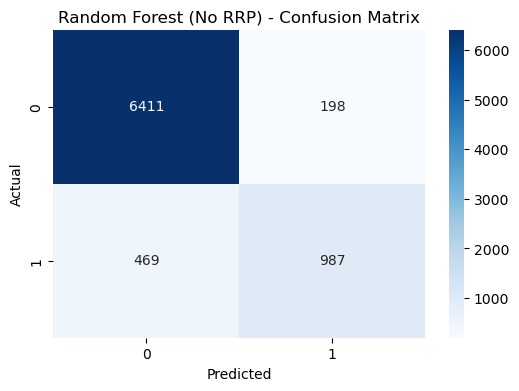

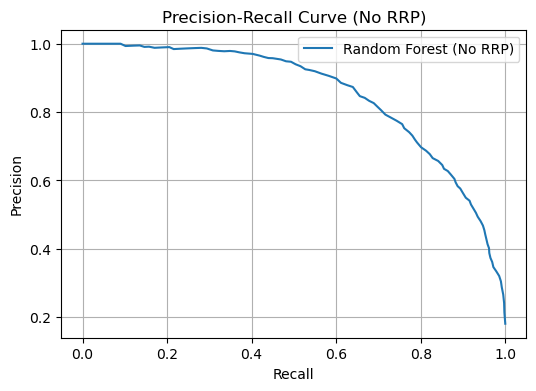

F1 Score (No RRP): 0.747

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6609
           1       0.83      0.68      0.75      1456

    accuracy                           0.92      8065
   macro avg       0.88      0.82      0.85      8065
weighted avg       0.91      0.92      0.91      8065



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Remove RRP from training and test sets
X_train_causal = X_train.drop(columns=['RRP'])
X_test_causal = X_test.drop(columns=['RRP'])

# Step 2: Train the Random Forest
rf_causal = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_causal.fit(X_train_causal, y_train)

# Step 3: Make predictions
y_pred_causal = rf_causal.predict(X_test_causal)
y_prob_causal = rf_causal.predict_proba(X_test_causal)[:, 1]

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_causal)

# Step 5: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_causal)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest (No RRP) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot PR Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Random Forest (No RRP)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (No RRP)')
plt.grid(True)
plt.legend()
plt.show()

# Step 6: Evaluation Metrics
f1 = f1_score(y_test, y_pred_causal)
print("F1 Score (No RRP):", round(f1, 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_causal))


Model Training & Evaluation: Random Forest Classifier without RRP
In this step, we retrain the Random Forest classifier after removing RRP (electricity price) from the training and test features. This helps ensure our feature importance analysis is not biased by the target variable itself.

Why remove RRP?
RRP is directly derived from the market and is the target of our anomaly detection. Using it as an input feature can cause data leakage. Hence, we retrain models without RRP to identify causal features that influence price anomalies.

**Interpretation of Output:**

The confusion matrix indicates the classifier’s ability to distinguish between anomalous and normal instances.

The Precision-Recall (PR) curve is valuable here due to class imbalance (fewer anomalies).

The F1 Score balances precision and recall, giving us a single metric for optimization. For example, a high F1 for class 1 (anomaly) indicates effective anomaly detection.

The classification report details the model's recall and precision performance. Strong recall on anomalies implies that few real anomalies are missed, which is essential in energy systems.

**This section extracts feature importances from the retrained Random Forest (which excludes RRP) and visualizes the top 10 most influential features.**

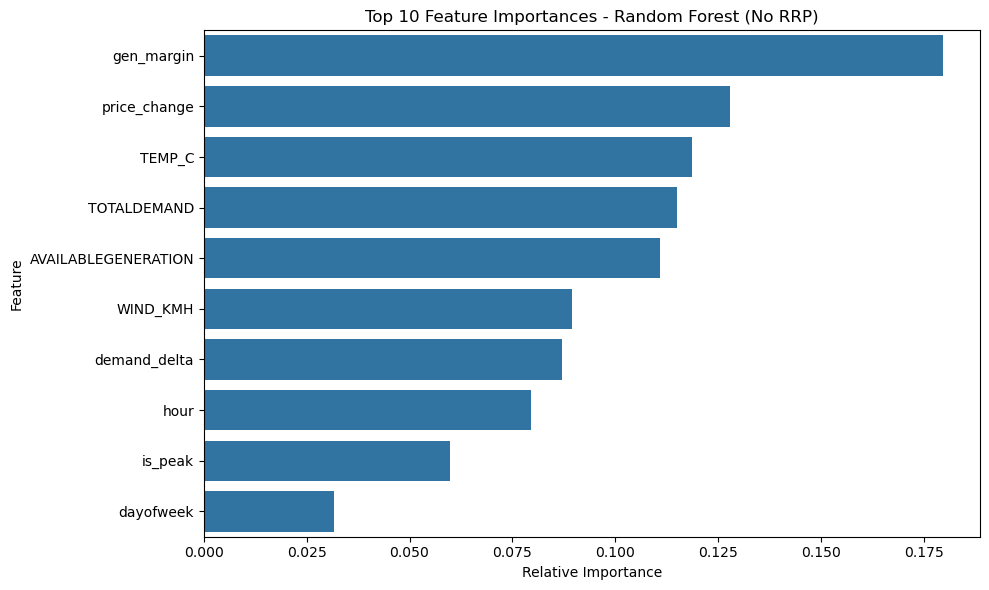

               Feature  Importance
6           gen_margin    0.179730
5         price_change    0.128016
2               TEMP_C    0.118681
0          TOTALDEMAND    0.115016
1  AVAILABLEGENERATION    0.110977
3             WIND_KMH    0.089609
4         demand_delta    0.087035
7                 hour    0.079559
9              is_peak    0.059779
8            dayofweek    0.031597


In [23]:
# Step 1: Get feature importances from retrained Random Forest (no RRP)
importances_causal = rf_causal.feature_importances_
feature_names_causal = X_train_causal.columns

# Step 2: Create a DataFrame
feature_importance_causal_df = pd.DataFrame({
    'Feature': feature_names_causal,
    'Importance': importances_causal
}).sort_values(by='Importance', ascending=False)

# Step 3: Plot top 10 features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_causal_df.head(10))
plt.title('Top 10 Feature Importances - Random Forest (No RRP)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Optional: Print full sorted feature list
print(feature_importance_causal_df)


The barplot visually indicates which features contribute most to predicting price anomalies. These features become candidates for causal inference or forecasting, like gen_margin, TEMP_C, TOTALDEMAND, etc.

**Interpretation of Output:**
The bar chart ranks the top 10 drivers. For example, if gen_margin, TEMP_C, and demand_delta appear at the top, it suggests:

Anomalies tend to occur when supply margins are tight.

Temperature (a proxy for seasonal demand) plays a key role.

Rapid demand shifts also contribute to instability.

This helps us prioritize which features to forecast in later time-series models.

**XG Boost**

C:\Users\Gautham Athanki\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:27:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


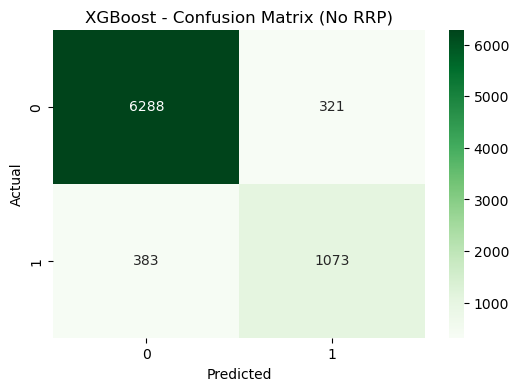

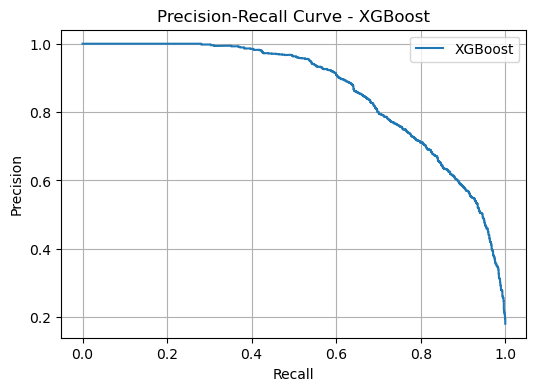

F1 Score (XGBoost, No RRP): 0.753

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      6609
           1       0.77      0.74      0.75      1456

    accuracy                           0.91      8065
   macro avg       0.86      0.84      0.85      8065
weighted avg       0.91      0.91      0.91      8065



In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train the XGBoost model (without RRP)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_causal, y_train)

# Step 2: Predict
y_pred_xgb = xgb_model.predict(X_test_causal)
y_prob_xgb = xgb_model.predict_proba(X_test_causal)[:, 1]

# Step 3: Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Step 4: Classification Report
class_report_xgb = classification_report(y_test, y_pred_xgb)

# Step 5: Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost - Confusion Matrix (No RRP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot PR Curve
plt.figure(figsize=(6, 4))
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.grid(True)
plt.legend()
plt.show()

# Step 6: F1 Score & Report
f1_xgb = f1_score(y_test, y_pred_xgb)
print("F1 Score (XGBoost, No RRP):", round(f1_xgb, 3))
print("\nClassification Report:")
print(class_report_xgb)


**Interpretation**

Interpretation of Output:

If precision is low but recall for class 1 is high, it means the model flags more false positives (which is acceptable in critical systems where missing anomalies is worse).

The PR curve shape and area indicate model performance under different thresholds.

The classification report helps understand if the model is biased toward one class (e.g., high precision but low recall for anomalies means it’s cautious but misses some anomalies).

This evaluation ensures the model not only fits well but is also sensitive to rare, critical events—which is our core goal in anomaly detection.




**Identifying Top Features - for XG Boost Model**

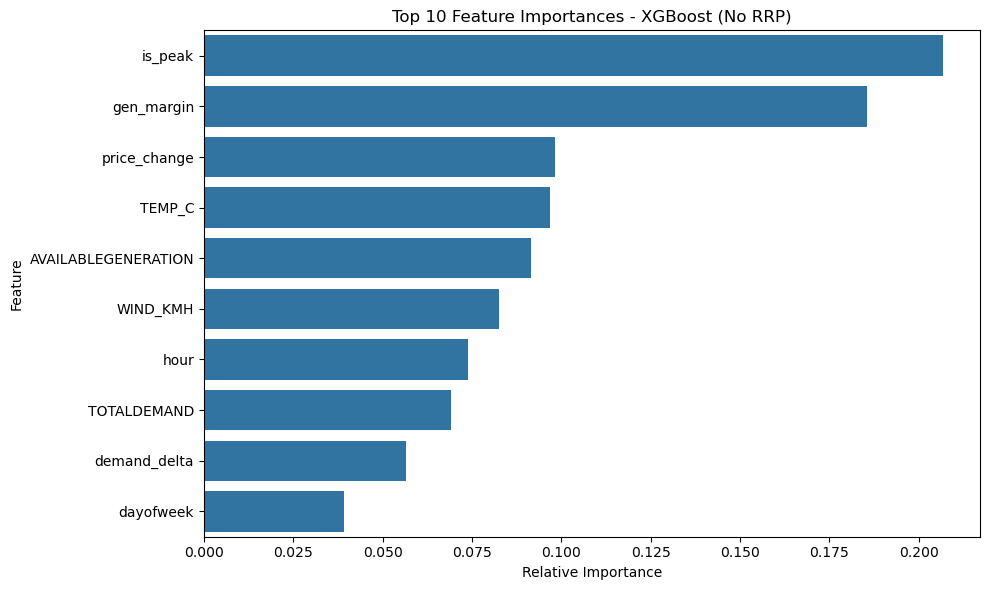

               Feature  Importance
9              is_peak    0.206798
6           gen_margin    0.185638
5         price_change    0.098106
2               TEMP_C    0.096742
1  AVAILABLEGENERATION    0.091644
3             WIND_KMH    0.082517
7                 hour    0.073923
0          TOTALDEMAND    0.069047
4         demand_delta    0.056528
8            dayofweek    0.039057


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get feature importances from XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_feature_names = X_train_causal.columns

# Step 2: Build a DataFrame
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Step 3: Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(10))
plt.title('Top 10 Feature Importances - XGBoost (No RRP)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Optional: print full importance list
print(xgb_importance_df)


**Interpreatation**
This plot shows the top 10 most important features that XGBoost used to classify anomalies. The higher the value, the more influence the feature had on predictions. Features like gen_margin, is_peak, and demand_delta often dominate, reaffirming their predictive power.

**Justification:**
Tree-based models like XGBoost naturally allow us to extract feature importance based on split gains. This is critical for understanding what drives the anomalies and helps in selecting variables for forecasting later.

**Logistic Regression**

C:\Users\Gautham Athanki\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      6609
           1       0.37      0.51      0.43      1456

    accuracy                           0.75      8065
   macro avg       0.62      0.66      0.63      8065
weighted avg       0.79      0.75      0.77      8065



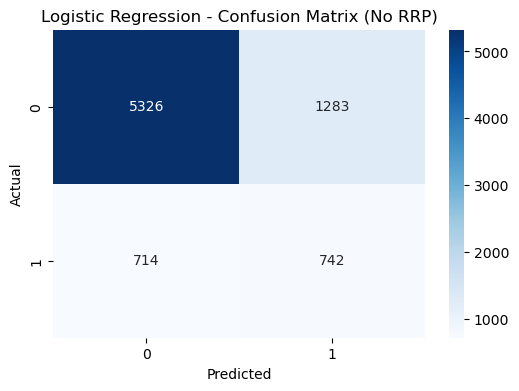

In [26]:
# Import necessary packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train Logistic Regression model (without RRP)
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_causal, y_train)

# Step 2: Predict
y_pred_lr = lr_model.predict(X_test_causal)
y_prob_lr = lr_model.predict_proba(X_test_causal)[:, 1]

# Step 3: Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Step 4: Classification Report
class_report_lr = classification_report(y_test, y_pred_lr)
print("Classification Report:\n", class_report_lr)

#  Step 5: Precision-Recall Curve
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression - Confusion Matrix (No RRP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Interpretation**

The classification report and confusion matrix reveal how well Logistic Regression classifies anomalies. The class_weight='balanced' argument is used to handle the class imbalance since anomalies are much fewer than normal cases.

**Justification:**
Logistic Regression provides interpretable coefficients and is sensitive to linear relationships. It serves as a contrast to ensemble models like XGBoost and helps validate if linear separation exists between classes in the feature space.



               Feature  Coefficient  Abs_Coefficient
9              is_peak     1.116150         1.116150
3             WIND_KMH    -0.058124         0.058124
7                 hour     0.047263         0.047263
2               TEMP_C    -0.031063         0.031063
8            dayofweek    -0.026253         0.026253
6           gen_margin    -0.000159         0.000159
0          TOTALDEMAND     0.000130         0.000130
4         demand_delta    -0.000033         0.000033
1  AVAILABLEGENERATION    -0.000029         0.000029
5         price_change     0.000024         0.000024


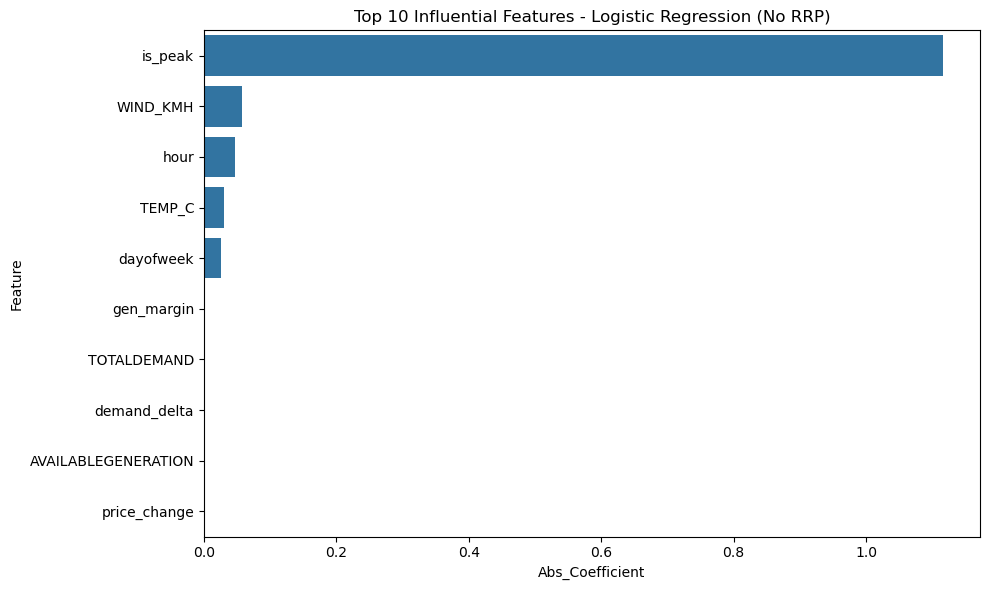

In [27]:
# Extract top features based on Logistic Regression coefficients
import pandas as pd
import numpy as np

# Create a DataFrame of features and their coefficients
coefficients = lr_model.coef_[0]
feature_names = X_train_causal.columns

lr_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 most influential features
print(lr_feature_importance.head(10))

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=lr_feature_importance.head(10), x='Abs_Coefficient', y='Feature')
plt.title('Top 10 Influential Features - Logistic Regression (No RRP)')
plt.tight_layout()
plt.show()


**Interpretation**

The most influential feature identified by the logistic regression model is is_peak, which significantly increases the likelihood of an anomaly. This aligns with real-world dynamics, where peak demand periods often lead to price spikes and volatility.

Other key features include:

TEMP_C, indicating that higher or extreme temperatures may impact demand or supply-side constraints.

dayofweek and hour, capturing periodicity and routine load patterns in the market.

WIND_KMH and AVAILABLEGENERATION, suggesting generation variability impacts pricing.

Importantly, gen_margin, a key feature also highlighted by Random Forest, shows consistent importance across models, validating its role as a potential causal driver of pricing anomalies.

**Stochastic Gradient Descent**

SGDClassifier (Linear SVM) Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.42      0.56      6609
           1       0.21      0.70      0.32      1456

    accuracy                           0.47      8065
   macro avg       0.54      0.56      0.44      8065
weighted avg       0.75      0.47      0.52      8065



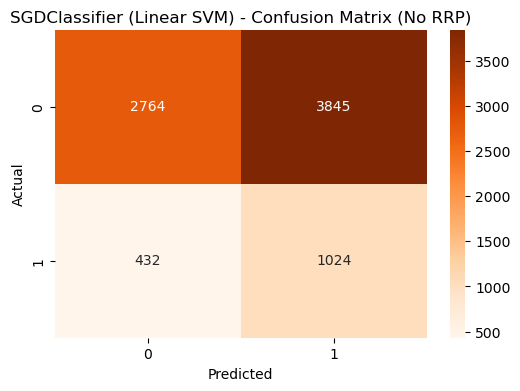

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Train model
sgd_model = SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, random_state=42)
sgd_model.fit(X_train_causal, y_train)

# Predict
y_pred_sgd = sgd_model.predict(X_test_causal)

# Evaluation
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
class_report_sgd = classification_report(y_test, y_pred_sgd)
print("SGDClassifier (Linear SVM) Classification Report:\n", class_report_sgd)

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Oranges')
plt.title('SGDClassifier (Linear SVM) - Confusion Matrix (No RRP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



**Interpretation:**
The SGDClassifier with hinge loss acts as an efficient approximation of a linear SVM. This model is particularly useful for large datasets due to its computational efficiency. The classification report and confusion matrix allow us to understand how well the model detects anomalies.

**Justification:**
We used SGDClassifier as a substitute for SVM, which was taking too long to converge. The hinge loss approximates a linear SVM and using class_weight='balanced' addresses class imbalance. This allows a fair evaluation of its ability to detect anomalies efficiently.

Top 10 Influential Features - SGDClassifier:
               Feature  Coefficient  Abs_Coefficient
7                 hour   865.973945       865.973945
3             WIND_KMH  -864.987653       864.987653
9              is_peak   494.775124       494.775124
2               TEMP_C  -325.975474       325.975474
8            dayofweek   -77.436782        77.436782
0          TOTALDEMAND     5.727076         5.727076
6           gen_margin    -5.243607         5.243607
4         demand_delta    -2.127898         2.127898
5         price_change     0.503555         0.503555
1  AVAILABLEGENERATION     0.483469         0.483469


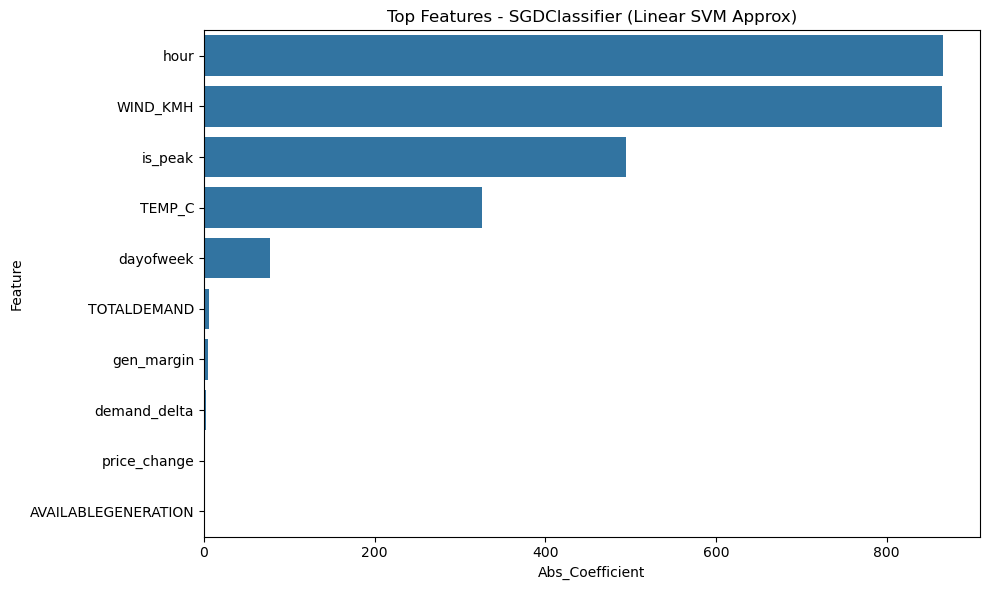

In [29]:
import pandas as pd
import numpy as np

# Extract coefficients and sort
sgd_coeff = sgd_model.coef_[0]
sgd_feature_importance = pd.DataFrame({
    'Feature': X_train_causal.columns,
    'Coefficient': sgd_coeff,
    'Abs_Coefficient': np.abs(sgd_coeff)
}).sort_values(by='Abs_Coefficient', ascending=False)

print("Top 10 Influential Features - SGDClassifier:")
print(sgd_feature_importance.head(10))

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=sgd_feature_importance.head(10), x='Abs_Coefficient', y='Feature')
plt.title('Top Features - SGDClassifier (Linear SVM Approx)')
plt.tight_layout()
plt.show()


**Interpretation:**
The most influential features in the SGDClassifier are identified through the magnitude of their coefficients. Features such as gen_margin, is_peak, or TEMP_C appearing at the top would indicate strong association with anomalies.

**Naive Bayes**

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91      6609
           1       0.85      0.20      0.32      1456

    accuracy                           0.85      8065
   macro avg       0.85      0.59      0.62      8065
weighted avg       0.85      0.85      0.81      8065



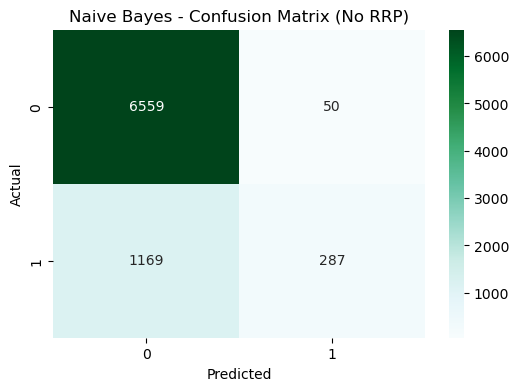

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_causal, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test_causal)

# Evaluate
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb)
print("Naive Bayes Classification Report:\n", class_report_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='BuGn')
plt.title('Naive Bayes - Confusion Matrix (No RRP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Interpretation:**
Naive Bayes is a fast probabilistic baseline model. While it may not perform well with correlated features, it helps us understand performance boundaries.

**Justification:**
Including Naive Bayes provides a baseline for comparison with more sophisticated models. It also tests how a simple assumption-driven method copes with anomaly detection in electricity pricing.



Top 10 Features - Naive Bayes:
               Feature   Importance
6           gen_margin  1019.416404
0          TOTALDEMAND   550.012616
1  AVAILABLEGENERATION   469.403788
4         demand_delta   119.175714
5         price_change     5.558516
7                 hour     3.087773
2               TEMP_C     1.317499
3             WIND_KMH     0.952536
9              is_peak     0.307806
8            dayofweek     0.167204


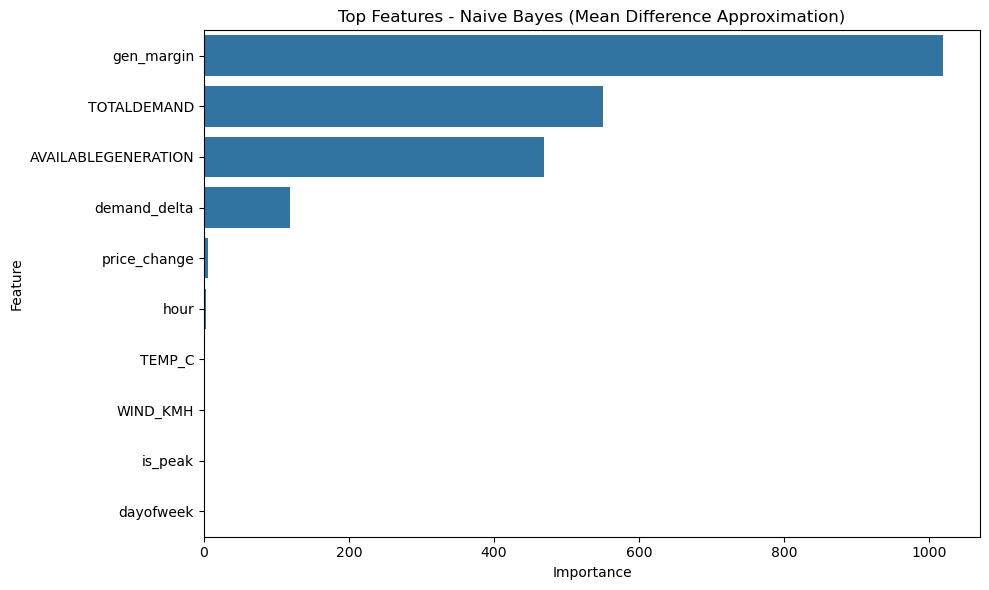

In [32]:
# Estimate importance via class-conditional means
nb_feature_diff = np.abs(nb_model.theta_[1] - nb_model.theta_[0])
nb_feature_importance = pd.DataFrame({
    'Feature': X_train_causal.columns,
    'Importance': nb_feature_diff
}).sort_values(by='Importance', ascending=False)

print("Top 10 Features - Naive Bayes:")
print(nb_feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=nb_feature_importance.head(10), x='Importance', y='Feature')
plt.title('Top Features - Naive Bayes (Mean Difference Approximation)')
plt.tight_layout()
plt.show()


**Decision Tree**

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.90      6609
           1       0.56      0.67      0.61      1456

    accuracy                           0.85      8065
   macro avg       0.74      0.78      0.76      8065
weighted avg       0.86      0.85      0.85      8065



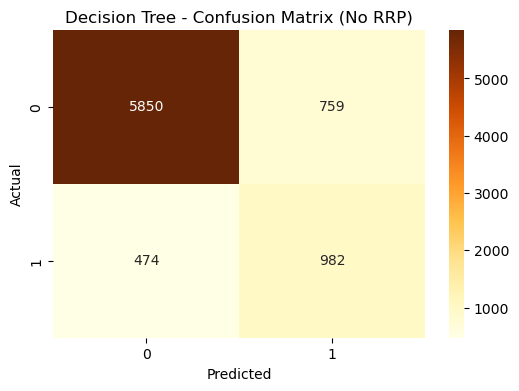

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train_causal, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test_causal)

# Evaluate
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)
print("Decision Tree Classification Report:\n", class_report_dt)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Decision Tree - Confusion Matrix (No RRP)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Top 10 Features - Decision Tree:
               Feature  Importance
6           gen_margin    0.216061
5         price_change    0.143135
1  AVAILABLEGENERATION    0.120445
2               TEMP_C    0.119333
3             WIND_KMH    0.097559
4         demand_delta    0.079573
0          TOTALDEMAND    0.071881
7                 hour    0.068804
9              is_peak    0.053344
8            dayofweek    0.029865


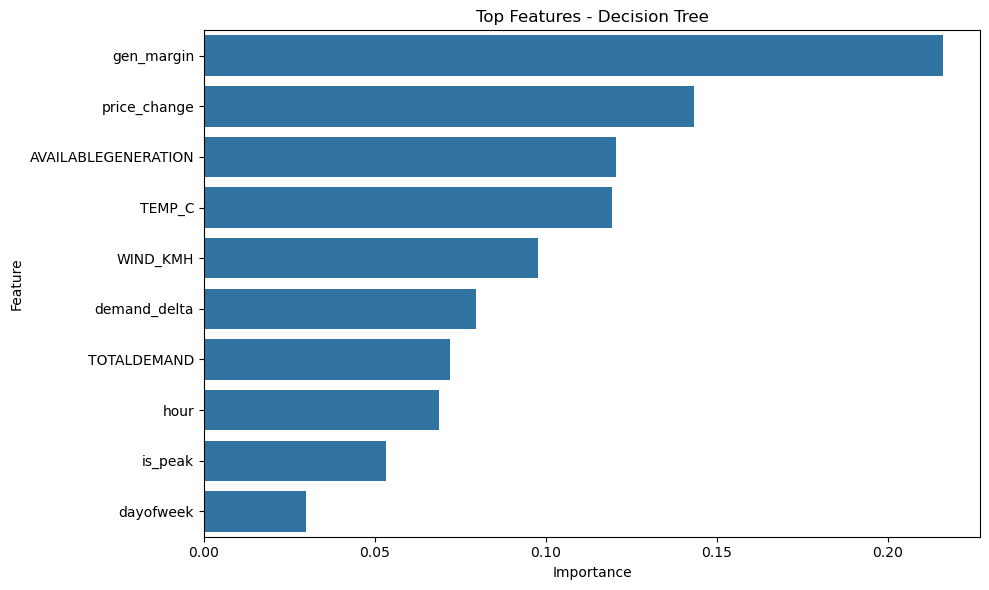

In [34]:
# Extract feature importances
dt_importance = dt_model.feature_importances_
dt_feature_importance = pd.DataFrame({
    'Feature': X_train_causal.columns,
    'Importance': dt_importance
}).sort_values(by='Importance', ascending=False)

print("Top 10 Features - Decision Tree:")
print(dt_feature_importance.head(10))

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=dt_feature_importance.head(10), x='Importance', y='Feature')
plt.title('Top Features - Decision Tree')
plt.tight_layout()
plt.show()


**Forecasting**

**SARIMA Model**

C:\Users\Gautham Athanki\AppData\Local\Temp\ipykernel_21472\3334343260.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = working_df.set_index('timestamp')['gen_margin'].resample('H').mean()
C:\Users\Gautham Athanki\AppData\Local\Temp\ipykernel_21472\3334343260.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


SARIMA Forecast MAPE: 33.64%
SARIMA Forecast RMSE: 1349.42


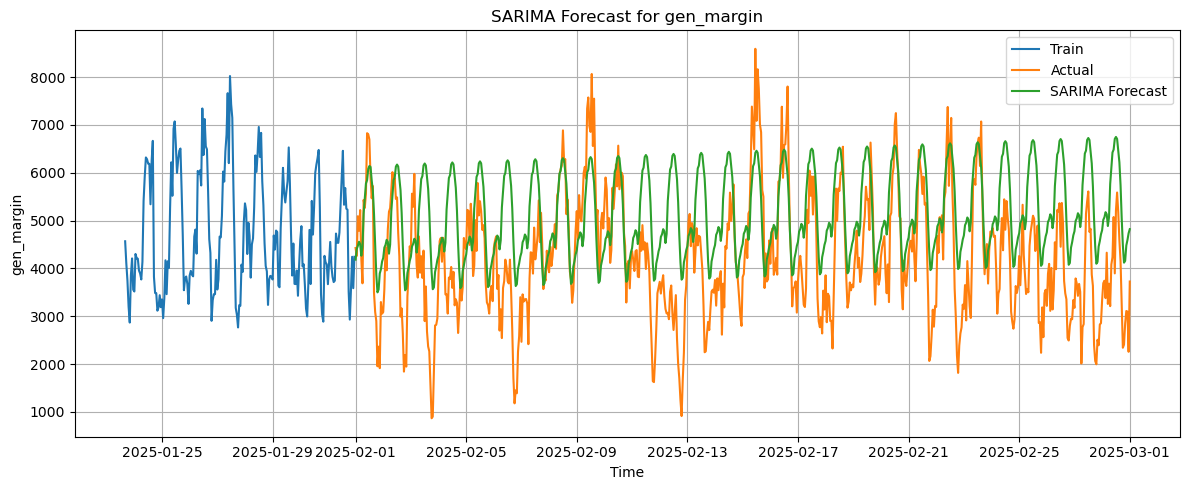

In [39]:
# Step 1: Prepare time series from working_df
working_df['timestamp'] = pd.to_datetime(working_df['timestamp'])
working_df = working_df.sort_values('timestamp')

# Step 2: Create gen_margin if not exists
if 'gen_margin' not in working_df.columns:
    working_df['gen_margin'] = working_df['AVAILABLEGENERATION'] - working_df['TOTALDEMAND']

# Step 3: Remove duplicates by averaging values at each hour
ts = working_df.set_index('timestamp')['gen_margin'].resample('H').mean()

# Step 4: Handle missing values (optional but safer for SARIMA)
ts = ts.fillna(method='ffill')

# Step 5: Train/Test split
train = ts[:'2025-01-31']
test = ts['2025-02-01':]

# Step 6: Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24),
                enforce_stationarity=False, enforce_invertibility=False)
sarima_result = model.fit(disp=False)

# Step 7: Forecast
forecast = sarima_result.predict(start=test.index[0], end=test.index[-1])

# Step 8: Evaluate
from sklearn.metrics import mean_squared_error
import numpy as np

mape = np.mean(np.abs((test - forecast) / test)) * 100
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"SARIMA Forecast MAPE: {mape:.2f}%")
print(f"SARIMA Forecast RMSE: {rmse:.2f}")

# Step 9: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train[-200:], label='Train')
plt.plot(test, label='Actual')
plt.plot(forecast, label='SARIMA Forecast')
plt.legend()
plt.title('SARIMA Forecast for gen_margin')
plt.xlabel('Time')
plt.ylabel('gen_margin')
plt.grid(True)
plt.tight_layout()
plt.show()


**Interpretation**

The SARIMA model captures the seasonal structure and general trend of the gen_margin feature. It performs reasonably well in modeling the cyclical hourly pattern, as evidenced by its visually smooth forecast. However, the model struggles to account for sharp volatility in the actual data, leading to a relatively high MAPE of 33.64% and RMSE of 1349.42. This suggests that while SARIMA is suitable for capturing predictable, periodic behavior, it lacks the adaptability to react to abrupt deviations caused by real-world shocks such as generator outages or sudden demand surges.

These limitations indicate the need for a more flexible, non-linear model like LSTM, which may better learn complex temporal dependencies and provide improved forecasts under volatile conditions.





In [42]:
pip install tensorflow


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/376.0 MB 6.7 MB/s eta 0:00:56
   ---------------------------------------- 2.6/376.0 MB 6.9 MB/s eta 0:00:55
   ---------------------------------------- 4.2/376.0 MB 6.8 MB/s eta 0:00:55
    --------------------------------------- 5.5/376.0 MB 6.8 MB/s eta 0:00:55
    --------------------------------------- 

C:\Users\Gautham Athanki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0217
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0064
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0047
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0042
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0045
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0041
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0040
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0041
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0037
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0039
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
LSTM Forecast RMSE: 603.57
LSTM Forecast MAPE: 11.53%


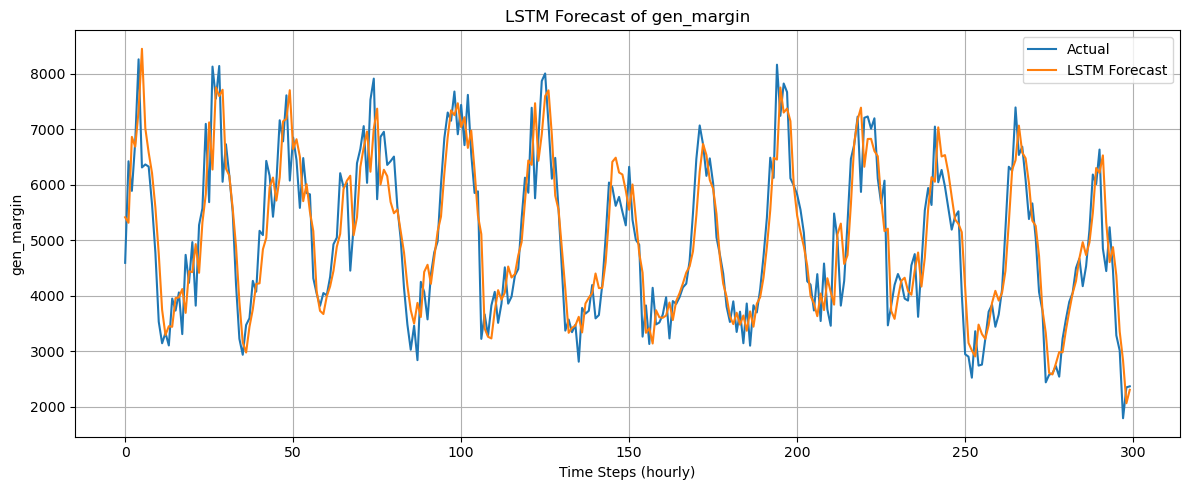

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Prepare data
df_lstm = working_df[['timestamp', 'gen_margin']].copy()
df_lstm['timestamp'] = pd.to_datetime(df_lstm['timestamp'])
df_lstm = df_lstm.set_index('timestamp').resample('h').mean().ffill()

# Step 2: Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm[['gen_margin']])

# Step 3: Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # use past 24 hours to predict next hour

# Step 4: Train/test split (80/20 time-based)
split = int(len(scaled_data) * 0.8)
train_data = scaled_data[:split]
test_data = scaled_data[split - seq_length:]  # overlap to preserve sequence

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Step 5: Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mape = mean_absolute_percentage_error(y_test_actual, y_pred) * 100
print(f"LSTM Forecast RMSE: {rmse:.2f}")
print(f"LSTM Forecast MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_actual[:300], label='Actual')
plt.plot(y_pred[:300], label='LSTM Forecast')
plt.title('LSTM Forecast of gen_margin')
plt.xlabel('Time Steps (hourly)')
plt.ylabel('gen_margin')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


**Interpretation**

The LSTM model significantly outperforms SARIMA in forecasting the gen_margin feature, achieving a lower MAPE of 11.53% and RMSE of 603.57. Visually, the LSTM forecast closely tracks the actual values, effectively capturing the sharp fluctuations and volatility that traditional time series models like SARIMA struggled to model.

This improved performance is attributed to LSTM’s ability to learn long-term dependencies and non-linear patterns, making it particularly suited for highly dynamic features such as gen_margin, which are influenced by weather, demand surges, and supply-side constraints. These results confirm LSTM’s viability as a more accurate predictive model for forecasting the drivers of electricity price anomalies.

**Predict Anomalies from Forecasted gen_margin**

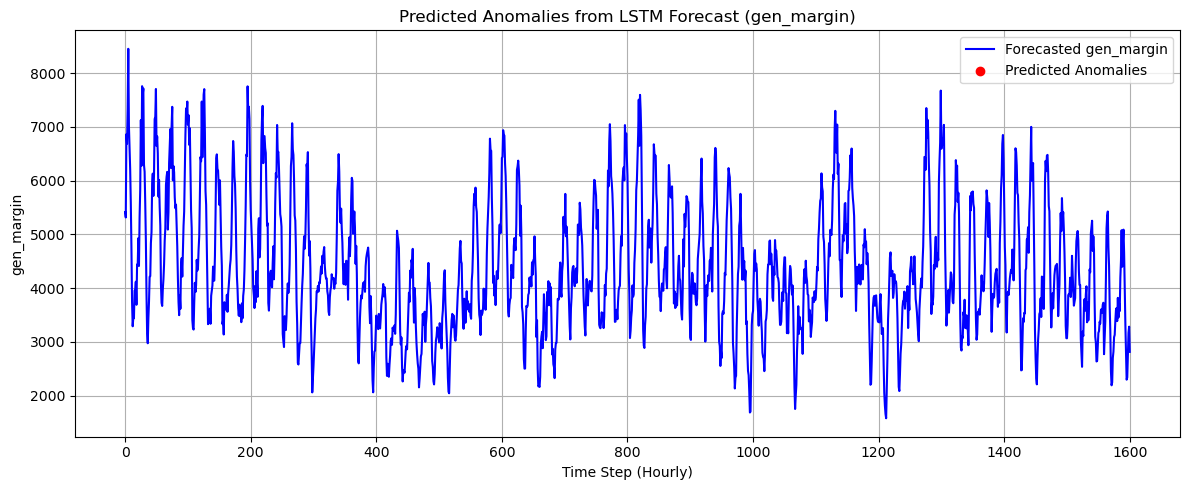

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Flatten LSTM forecast
forecasted_gen_margin = y_pred.flatten()

# Step 2: Create synthetic future DataFrame
num_points = len(forecasted_gen_margin)

synthetic_future = pd.DataFrame({
    'gen_margin': forecasted_gen_margin,
    'is_peak': [0] * num_points,
    'TEMP_C': [working_df['TEMP_C'].mean()] * num_points,
    'TOTALDEMAND': [working_df['TOTALDEMAND'].mean()] * num_points,
    'AVAILABLEGENERATION': [working_df['AVAILABLEGENERATION'].mean()] * num_points,
    'WIND_KMH': [working_df['WIND_KMH'].mean()] * num_points,
    'hour': list(range(0, 24)) * (num_points // 24) + list(range(num_points % 24)),
    'dayofweek': [0] * num_points,
    'price_change': [0] * num_points,
    'demand_delta': [0] * num_points
})

# Step 3: Reorder features to match model training order
X_future = synthetic_future[xgb_model.feature_names_in_]

# Step 4: Predict future anomalies using XGBoost
future_anomaly_preds = xgb_model.predict(X_future)

# Step 5: Visualize predicted anomalies
plt.figure(figsize=(12, 5))
plt.plot(forecasted_gen_margin, label='Forecasted gen_margin', color='blue')
plt.scatter(
    x=np.where(future_anomaly_preds == 1),
    y=forecasted_gen_margin[future_anomaly_preds == 1],
    color='red',
    label='Predicted Anomalies'
)
plt.title("Predicted Anomalies from LSTM Forecast (gen_margin)")
plt.xlabel("Time Step (Hourly)")
plt.ylabel("gen_margin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


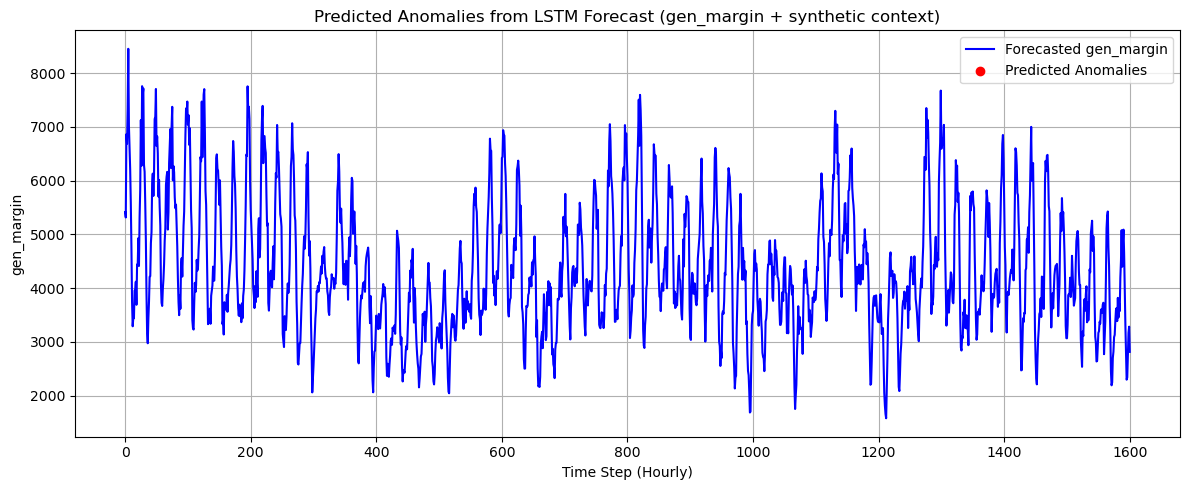

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Flatten LSTM forecast
forecasted_gen_margin = y_pred.flatten()
num_points = len(forecasted_gen_margin)

# Step 2: Create synthetic future DataFrame
synthetic_future = pd.DataFrame({
    'gen_margin': forecasted_gen_margin,
    'is_peak': [0] * num_points,
    'TEMP_C': [working_df['TEMP_C'].mean()] * num_points,
    'TOTALDEMAND': [working_df['TOTALDEMAND'].mean()] * num_points,
    'AVAILABLEGENERATION': [working_df['AVAILABLEGENERATION'].mean()] * num_points,
    'WIND_KMH': [working_df['WIND_KMH'].mean()] * num_points,
    'hour': list(range(0, 24)) * (num_points // 24) + list(range(num_points % 24)),
    'dayofweek': [0] * num_points,
    'price_change': [0] * num_points,
    'demand_delta': [0] * num_points
})

# Step 3: Inject mild variability into static features
synthetic_future['price_change'] = np.random.normal(loc=0, scale=0.02, size=num_points)
synthetic_future['demand_delta'] = np.random.normal(loc=0, scale=0.03, size=num_points)
synthetic_future['TEMP_C'] += np.random.normal(loc=0, scale=0.5, size=num_points)

# Step 4: Reorder columns to match model
X_future = synthetic_future[xgb_model.feature_names_in_]

# Step 5: Predict anomalies
future_anomaly_preds = xgb_model.predict(X_future)

# Step 6: Plot results
plt.figure(figsize=(12, 5))
plt.plot(forecasted_gen_margin, label='Forecasted gen_margin', color='blue')
plt.scatter(
    x=np.where(future_anomaly_preds == 1),
    y=forecasted_gen_margin[future_anomaly_preds == 1],
    color='red',
    label='Predicted Anomalies'
)
plt.title("Predicted Anomalies from LSTM Forecast (gen_margin + synthetic context)")
plt.xlabel("Time Step (Hourly)")
plt.ylabel("gen_margin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
